## Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных и библиотек

In [1]:
# загружаем библиотеки
import numpy as np
import pandas as pd
from datetime import datetime
import re, time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
plt.style.use('seaborn')
SEED = 777

In [3]:
# загружаем данные
try:
    df = pd.read_csv('../01-data/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except FileNotFoundError:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [4]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


In [5]:
# сразу приведем названия переменных из camel в snake case
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in df.columns]

In [6]:
# выведем общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Данные загружены, в датасете имеется свыше 350 тыс. объектов, 3 признака типа дата, 7 числовых признаков (2 из которых также имеют отношение к дате) и 6 категориальных признаков.

Значения признаков:

-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	NotRepaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

Целевой признак - **price** — цена в евро

От нескольких признаков, которые не пригодятся ни для EDA, ни для моделирования, можно избавиться сразу: number_of_pictures (все значения нулевые), date_crawled, postal_code, last_seen.

In [7]:
df = df.drop(columns=['number_of_pictures', 'date_crawled', 'postal_code', 'last_seen'], axis=1)

### Предобработка данных

In [8]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0


В данных много аномальных значений: есть машины как из будущего, так и далекого прошлого, автомобили с мощностью танкера и др. Для целей моделирования от таких объектов лучше избавиться, т.к. возраст и мощность автомобиля существенно влияют на его стоимость.

Удалим объекты с годом регистрации до 1960 года (это категория относится уже скорее к антиквариату) и превышающем дату создания объекта (записи были созданы в 2014-2016 годах).

In [9]:
# индекс строк к удалению
years_to_drop = df[(df.registration_year > df['date_created'].dt.year) | (df.registration_year < 1960)].index

print(f'Всего объектов с аномальными годами - {len(df.loc[years_to_drop])} \
или {len(df.loc[years_to_drop]) / len(df):.2%} датасета')

# удаляем объекты
df = df.drop(years_to_drop)

Всего объектов с аномальными годами - 14952 или 4.22% датасета


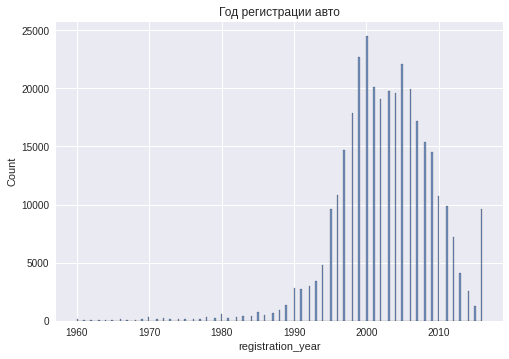

In [10]:
sns.histplot(df.registration_year)
plt.title('Год регистрации авто')
plt.show()

Изучим данные о мощности автомобилей.

Распределение мощности автомобилей


(0.0, 500.0)

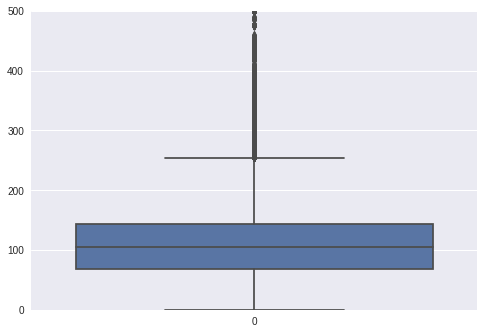

In [11]:
print('Распределение мощности автомобилей')
_ = sns.boxplot(data=df.power)
plt.ylim(0, 500)

In [12]:
len(df[df.power == 0])

36258

В распределении мощности автомобилей наблюдается большое количество (свыше 10%) нулевых значений и длинный хвост аномально больших значений. Нулевые значения оставим как есть (посмотрим на них на стадии моделирования), а верхний потолок ограничим 600 л.с. (дальше идут только редкие гоночные болиды).

In [13]:
df = df[df.power <= 600]

Распределение мощности автомобилей после обрезки:


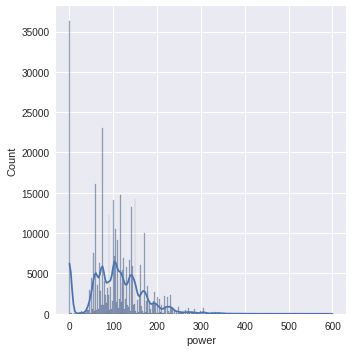

In [14]:
print('Распределение мощности автомобилей после обрезки:')
_ = sns.displot(df.power, kde=True)

В данных о цене много нулевых значений. Если их оставить, модели получат неверную установку, что целевая переменная может быть нулевой, что не соответствует действительности. Кроме того, не несут пользы и аномально низкие значения цены. Установим отсечку в данных на уровне 300 евро (это 7%-й квантиль), прочие записи удалим.

In [15]:
df = df[df.price >= 300]

Распределение цены автомобилей после обрезки:


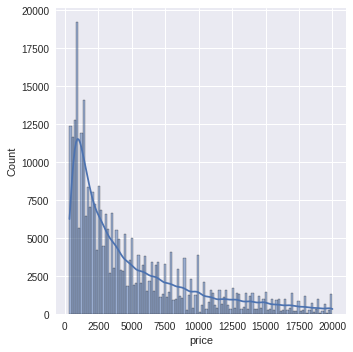

In [16]:
print('Распределение цены автомобилей после обрезки:')
_ = sns.displot(df[df.price > np.quantile(df.price, 0.01)]['price'], kde=True)

Также имеются нулевые значения в переменной месяца постановки на учет, оставим их без изменения.

Столбец с датой создания объявления нам больше не пригодится, удалим его.

In [17]:
df = df.drop('date_created', axis=1)



Изучим имеющиеся пропуски.

In [18]:
def df_na(df):
    # функция подсчета пропущенных значений в переменных
    data = df.isna().sum()
    res = (pd.concat([data / df.shape[0], data], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    return res[res['abs'] > 0]

print('Пропуски в признаках:')
df_na(df)

Пропуски в признаках:


,percent,abs
not_repaired,0.170092,53941
fuel_type,0.065125,20653
vehicle_type,0.051679,16389
model,0.044200,14017
gearbox,0.041091,13031


В численных переменных пропусков нет, зато они имеются во всех категориальных признаках кроме производителя. Изучим их внимательнее.

In [19]:
cat_var = df.select_dtypes(exclude='number').columns.tolist()
num_var = df.select_dtypes(include='number').columns.tolist()
num_var.remove('price')
print(f'Категориальные признаки: {cat_var}')
print(f'Числовые признаки: {num_var}')


Категориальные признаки: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
Числовые признаки: ['registration_year', 'power', 'kilometer', 'registration_month']


In [20]:
df.describe(include='object')

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,300740,304098,303112,296476,317129,263188
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,87503,241827,25806,196267,68253,234129


In [21]:
df.groupby(by=['model'], dropna=False)[cat_var].count()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
model,,,,,,
100,361,365,377,352,377,294
145,28,29,31,28,31,26
147,483,510,526,508,526,454
156,529,538,553,514,553,455
159,198,203,203,194,203,189
...,...,...,...,...,...,...
yeti,171,171,172,170,172,167
ypsilon,162,167,172,161,172,149
z_reihe,696,686,700,687,700,659


Основания для заполнения пропусков какими-либо значения отсутствуют. Просто обозначим отсутствующие значения строкой unk - unknown.

In [22]:
df[cat_var] = df[cat_var].fillna('unk')

В данных типа топлива присутствует 2 класса - petrol и gasoline. Отставим только один, т.к. это разные названия одного и того же.

In [23]:
df.loc[df.fuel_type == 'gasoline', 'fuel_type'] = 'petrol'

In [24]:
# наличие явных дубликатов
print('Дубликатов:', df.duplicated().sum())

df = df.drop_duplicates()

Дубликатов: 25077


Выведем гистограммы и сводку в целом по датасету.

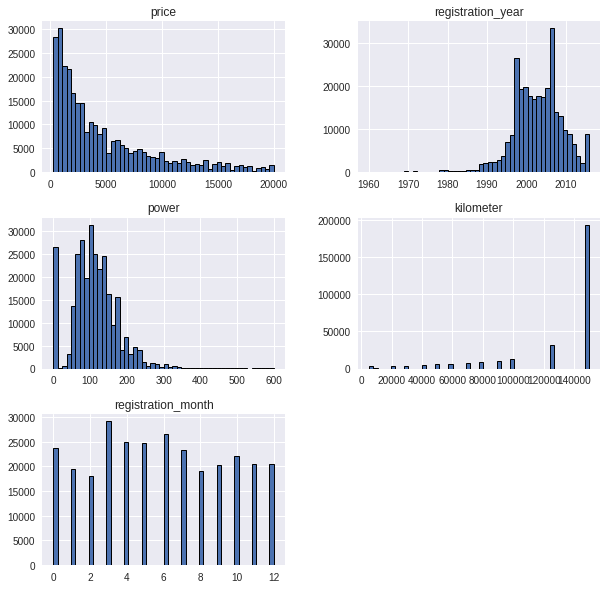

In [25]:
df.hist(bins=50, figsize=(10,10), edgecolor='black', linewidth=1)
plt.show()

Гистограммы числовых признаков и другие моменты указывают на то, что данные синтетические. Это хорошо заметно по показателю пробега, наличию случайных значений в мощности автомобилей и др.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292052 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               292052 non-null  int64 
 1   vehicle_type        292052 non-null  object
 2   registration_year   292052 non-null  int64 
 3   gearbox             292052 non-null  object
 4   power               292052 non-null  int64 
 5   model               292052 non-null  object
 6   kilometer           292052 non-null  int64 
 7   registration_month  292052 non-null  int64 
 8   fuel_type           292052 non-null  object
 9   brand               292052 non-null  object
 10  not_repaired        292052 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.7+ MB


### Разбивка данных

Разобьем данные на обучающую (75%) и тестовую (25%) выборки.

In [28]:
X = df.drop('price', axis=1)
y = df.price
X.shape, y.shape

((292052, 10), (292052,))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (219039, 10), y_train: (219039,)
X_test: (73013, 10), y_test: (73013,)


### Итоги предобработки

Мы загрузили, изучили и очистили данные от явных дубликатов, пропусков и видимых аномалий. В процессе предобработки было удалено около 18% записей и несколько признаков, что, как мы ожидаем, даст более релевантные данные для построения моделей.

По итогам предобработки мы подготовили данные для моделирования, разбив их на тренировочную и тестовые выборки. В процессе моделирования мы предполагаем использовать кросс-валидацию.

## Обучение моделей

Создадим функцию, которая позволит агрегировать данные о результатах использования разных моделей.

In [30]:
def modelling(model, x, y, x_test, y_test, name='model'):
    start = time.perf_counter()
    model = model
    model.fit(x, y)
    train_time = time.perf_counter() - start
    
    rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
    r2 = r2_score(y_test, model.predict(x_test))
    pred_time = time.perf_counter() - start - train_time
    print(f'RMSE = {rmse:.0f}, R2 = {r2:.2f}')
    return name, rmse, r2, train_time, pred_time

models = []

### Линейная регрессия

В начале посмотрим как работает с нашими данными модель линейной регрессии. Отмасштабирует числовые признаки и передадим их в конвейер, который переведет категориальные признаки в числовые прямым кодированием.

In [32]:
scaler = StandardScaler()
scaler.fit(X_train[num_var])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_var] = scaler.transform(X_train_scaled[num_var])
X_test_scaled[num_var] = scaler.transform(X_test_scaled[num_var])

In [33]:
lr_pipe = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore')),
    ('model', LinearRegression())
])

In [34]:
models.append(modelling(lr_pipe, X_train_scaled, y_train, X_test_scaled, y_test, name='Linear Regression'))

RMSE = 2022, R2 = 0.80


### Lasso

В данном проекте мы протестировали модель Lasso:
```python
    lasso_pipe = Pipeline([
                            ('ohe', OneHotEncoder(handle_unknown='ignore')),
                            ('scaler', StandardScaler(with_mean=False)),
                            ('model', LassoCV(random_state=SEED))
                            ])
    lasso = LassoCV(random_state = SEED)
    models.append(modelling(lasso_pipe, X_train, y_train, X_test, y_test, name='Lasso'))

```
Ее результаты исключены из ноутбука в силу того, что метрики обучения почти не отличаются от линейной регрессии, а время обучения составило неприемлемые несколько часов.

Таким образом, признаем эту модель непригодной для решения задачи.

### LightGBM

Чтобы построить модель на LightGBM необходимо предварительно предобработать категориальные признаки. 

Используем для этого [OrdinalEncoder](https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder). Затем обучим модель с разными параметрами и, выбрав лучшие, посчитаем результаты модели.

In [36]:
enc = OrdinalEncoder()

lgbm_train = enc.fit_transform(X_train)
lgbm_test = enc.fit_transform(X_test)

lgbm_train.shape, lgbm_test.shape

((219039, 10), (73013, 10))

In [37]:
# установки для поиска гиперпараметров модели
lgbm_par = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'num_leaves' : [30, 50, 70],
    'n_estimators': [40, 80, 120]
}

cv = KFold(n_splits=3, shuffle=True, random_state=SEED)

lgbm = lgb.LGBMRegressor(max_depth=15, verbose=0, seed=SEED)

lgbm_grid = GridSearchCV(lgbm,
                    lgbm_par,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [ ]:
%%time
lgbm_grid.fit(lgbm_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.893037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.595034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.792435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.595056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [ ]:
# добавляем результаты модели LightGBM в сводную таблицу 
models.append(modelling(lgbm_grid.best_estimator_, lgbm_train, y_train, lgbm_test, y_test, name='LGBM'))

### CatBoost

Проведем обучение модели градиентного бустинга с помощью пакета CatBoost. CatBoost умеет обрабатывать категориальные признаки, поэтому дополнительная обработка данных не требуется. Также попробуем перебрать несколько гиперпараметров с помощью grid_search.

In [ ]:
cb = CatBoostRegressor(random_seed=SEED,
                        iterations=300,
                        silent=True,
                        cat_features=cat_var)

cb_par = {'depth': [5, 10],
        'l2_leaf_reg': [3, 5]}

In [ ]:
%%time
# обучаем модель с заданными параметрами
grid_cb = cb.grid_search(cb_par, X=X_train, y=y_train)

In [ ]:
# добавляем результаты модели CatBoost в сводную таблицу 
models.append(modelling(cb, X_train, y_train, X_test, y_test, name='CatBoost'))

Для сравнения попробуем посчитать с установками по умолчанию.

In [ ]:
%%time
cb2 = CatBoostRegressor(random_seed=SEED,
                        learning_rate=0.15,
                        silent=True,
                        cat_features=cat_var)

cb2.fit(X=X_train, y=y_train, eval_set=(X_test, y_test))

In [ ]:
models.append(modelling(cb2, X_train, y_train, X_test, y_test, name='CatBoost2'))

## Анализ моделей

In [ ]:
models_summary = pd.DataFrame(models, columns=['model', 'rmse', 'r2', 'train_time', 'pred_time'])
models_summary

По качеству предсказания выигрывает модель CatBoost, причем при дефолтных настройках параметров результаты лучше. В тоже время модель CatBoost требует существенно больше времени на обучение, чем тот же градиентный спуск с помощью LightGBM.


### Выводы:





Учитывая требования заказчика, наиболее подходящей моделью для прогнозирования стоимости автомобилей будет модель LightGBM - она дает быстрый результат приемлемого качества.
